In [1]:
import numpy as np
import pandas as pd

**I implemented the DCC-GARCH model on the daily returns of S&P500 index and of JP Morgan Chase & Co.**

**The trading data from 2010/01/01 to 2019/12/31 was downloaded from Yahoo Finance.**

In [2]:
sp = pd.read_csv('data/^GSPC.csv').set_index('Date')
jpm = pd.read_csv('data/JPM.csv').set_index('Date')

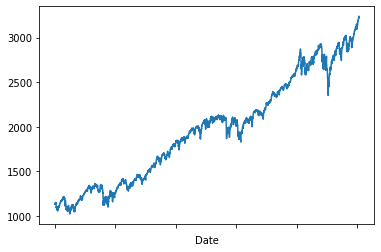

In [5]:
sp['Adj Close'].plot() # simple plot for S&P500 index

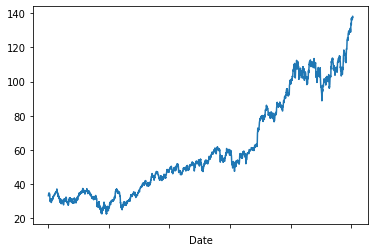

In [4]:
jpm['Adj Close'].plot() # simple plot for JP Morgan Chase & Co.

In [32]:
sp_return = np.log(sp['Adj Close']).diff().dropna() # log return of S&P500 index
jpm_return = np.log(jpm['Adj Close']).diff().dropna() # log return of JP Morgan Chase & Co.

In [33]:
sp_return = sp_return.iloc[::-1] # the latest data should come first
jpm_return = jpm_return.iloc[::-1] # the latest data should come first

**In accord with _Multivariate DCC-GARCH Model (Elisabeth Orskaug, 2009)_, a GARCH model was first fitted for each log return separately and then a DCC model was fitted for the cross-correlation between the two time series. Additionally, I used threhold GARCH (usually abbreviated to TGARCH) in order to better capture the asymmetry of the stock volatility.**

**The structure of the entire model can be written down as follows:**

\begin{align}
&\left[\begin{array}{c}
     r_{sp,t} \\
     r_{jpm,t} 
     \end{array}\right]  \sim N(0,H_t) \\
&H_t  = 
     \left[\begin{array}{cc}
     \sigma_{sp,t} & 0 \\
     0 & \sigma_{jpm,t} 
     \end{array}\right]
     \left[\begin{array}{cc}
     1 & \rho_t \\
     \rho_t & 1 
     \end{array}\right]
     \left[\begin{array}{cc}
     \sigma_{sp,t} & 0 \\
     0 & \sigma_{jpm,t} 
     \end{array}\right] = 
     \left[\begin{array}{cc}
     \sigma_{sp,t} & 0 \\
     0 & \sigma_{jpm,t} 
     \end{array}\right] 
     R_t
     \left[\begin{array}{cc}
     \sigma_{sp,t} & 0 \\
     0 & \sigma_{jpm,t} 
     \end{array}\right]\\
&R_t  = 
     \left[\begin{array}{cc}
     \frac{1}{\sqrt{q_{11,t}}} & 0 \\
     0 & \frac{1}{\sqrt{q_{22,t}}}
     \end{array}\right] 
     \left[\begin{array}{cc}
     q_{11,t} & q_{12,t} \\
     q_{12,t} & q_{22,t}
     \end{array}\right] 
     \left[\begin{array}{cc}
     \frac{1}{\sqrt{q_{11,t}}} & 0 \\
     0 & \frac{1}{\sqrt{q_{22,t}}}
     \end{array}\right] =
     \left[\begin{array}{cc}
     \frac{1}{\sqrt{q_{11,t}}} & 0 \\
     0 & \frac{1}{\sqrt{q_{22,t}}}
     \end{array}\right]
     Q_t
     \left[\begin{array}{cc}
     \frac{1}{\sqrt{q_{11,t}}} & 0 \\
     0 & \frac{1}{\sqrt{q_{22,t}}}
     \end{array}\right]\\
&\sigma_{sp,t}^2 = \omega_{sp} + \alpha_{sp}\cdot r_{sp,t-1}^2 + \gamma_{sp}\cdot r_{sp,t-1}^2 \cdot I_{sp,t-1}^{-} + \beta_{sp} \cdot \sigma_{sp,t-1}^2\\
&\sigma_{jpm,t}^2 = \omega_{jpm} + \alpha_{jpm}\cdot r_{jpm,t-1}^2 + \gamma_{jpm}\cdot r_{jpm,t-1}^2 \cdot I_{jpm,t-1}^{-} + \beta_{jpm} \cdot \sigma_{jpm,t-1}^2\\
&Q_t = (1-a-b)\cdot\bar{Q} + a\cdot\epsilon_{t-1}\epsilon_{t-1}' + b\cdot Q_{t-1}\\
&\bar{Q} = \dfrac{1}{T}\sum_{t=1}^{T}\epsilon_{t}\epsilon_{t}', \quad \epsilon_{t} = \left[\begin{array}{c}
     r_{sp,t}/\sigma_{sp,t} \\
     r_{jpm,t}/\sigma_{jpm,t}
     \end{array}\right]
\end{align}

**The parameters to be optimized are**

$\omega_{sp},\alpha_{sp},\gamma_{sp},\beta_{sp}$ **for the TGARCH(1,1,1) model fitting on the log return of S&P500 index,**

$\omega_{jpm},\alpha_{jpm},\gamma_{jpm},\beta_{jpm}$ **for the TGARCH(1,1,1) model fitting on the log return of JP Morgan Chase & Co.,**

**and $a,b$ for the DCC model fitting on the cross-correlation.**

In [8]:
from DCC_GARCH.GARCH.GARCH import GARCH
from DCC_GARCH.GARCH.GARCH_loss import garch_loss_gen

In [40]:
sp_model = GARCH(1,1)
sp_model.set_loss(garch_loss_gen(1, 1))
sp_model.set_max_itr(1)

In [41]:
sp_model.fit(sp_return)

Iteration: 1. Training loss: -2.157E+04.


[-21567.160758232643]

In [42]:
sp_model.get_theta()

array([1.98324814e-05, 9.50397998e-02, 8.58304014e-02, 5.99576332e-01])

**Therefore, we have the fitted TGARCH(1,1,1) on the log return of S&P500 index:**
\begin{align}
\omega_{sp}&= 1.983e-05\\
\alpha_{sp}&= 0.0950\\
\gamma_{sp}&= 0.0858\\
\beta_{sp}&= 0.5996
\end{align}

In [43]:
jpm_model = GARCH(1,1)
jpm_model.set_loss(garch_loss_gen(1, 1))
jpm_model.set_max_itr(1)

In [44]:
jpm_model.fit(jpm_return)

Iteration: 1. Training loss: -1.878E+04.


[-18779.847008676497]

In [45]:
jpm_model.get_theta()

array([7.41617844e-30, 1.33518229e-02, 3.10807721e-02, 9.71107791e-01])

**Therefore, we have the fitted TGARCH(1,1,1) on the log return of JP Morgan Chase & Co.:**
\begin{align}
\omega_{jpm}&= 7.416e-30\\
\alpha_{jpm}&= 0.0134\\
\gamma_{jpm}&= 0.0311\\
\beta_{jpm} &= 0.9711
\end{align}

In [46]:
sp_sigma = sp_model.sigma(sp_return)
sp_epsilon = sp_return / sp_sigma

In [50]:
jpm_sigma = jpm_model.sigma(jpm_return)
jpm_epsilon = jpm_return / jpm_sigma

In [51]:
epsilon = np.array([sp_epsilon,jpm_epsilon])

In [55]:
from DCC_GARCH.DCC.DCC import DCC
from DCC_GARCH.DCC.DCC_loss import dcc_loss_gen

In [58]:
dcc_model = DCC()
dcc_model.set_loss(dcc_loss_gen())

In [59]:
dcc_model.fit(epsilon)

C:\Users\XSe\Desktop\Systemic Risk\Python\SRISK\DCC_GARCH\DCC\DCC_loss.py:48: RuntimeWarning: invalid value encountered in log
  loss += np.log(np.linalg.det(Ri)) + np.dot(np.dot(ei,Ri_),ei)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3277.8886747323145
            Iterations: 23
            Function evaluations: 105
            Gradient evaluations: 23
Iteration: 1. Training loss: 3.278E+03.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3277.888674723196
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration: 2. Training loss: 3.278E+03.


[3277.8886747323145, 3277.888674723196]

In [60]:
dcc_model.get_ab()

array([0.01376197, 0.96359375])

**Therefore, we have the fitted DCC(1,1) for the cross-correlation between the log returns of S&P500 index and of JP Morgan Chase & Co.:**
\begin{align}
a &= 0.0138\\
b&= 0.9636
\end{align}